In [6]:
pip install torch==1.5.0+cu101 torchvision==0.6.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 703.8MB 26kB/s 
     |████████████████████████████████| 6.6MB 22.1MB/s 
  Found existing installation: torch 1.4.0
    Uninstalling torch-1.4.0:
      Successfully uninstalled torch-1.4.0
  Found existing installation: torchvision 0.5.0
    Uninstalling torchvision-0.5.0:
      Successfully uninstalled torchvision-0.5.0


In [1]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image

import math
import copy

from google.colab import drive
drive.mount('/content/drive')

class MLP(nn.Module):
  def __init__(self, n_units, init_scale=1.0):
    super(MLP, self).__init__()

    self._n_units = copy.copy(n_units)
    self._layers = []
    for i in range(1, len(n_units)):
      layer = nn.Linear(n_units[i-1], n_units[i], bias=False)
      variance = math.sqrt(2.0 / (n_units[i-1] + n_units[i]))
      layer.weight.data.normal_(0.0, init_scale * variance)
      self._layers.append(layer)

      name = 'fc%d' % i
      if i == len(n_units) - 1:
        name = 'fc'  # the prediction layer is just called fc
      self.add_module(name, layer)


  def forward(self, x):
    x = x.view(-1, self._n_units[0])
    out = self._layers[0](x)
    for layer in self._layers[1:]:
      out = F.relu(out)
      out = layer(out)
    return out



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd drive/'My Drive'

/content/drive/My Drive


In [0]:
mlp_spec = '512'
n_units = [int(x) for x in mlp_spec.split('x')] # hidden dims
n_units.append(10)  # output dim
n_units.insert(0, 32*32*3)        # input dim
model = MLP(n_units)
model = model.to("cuda:0")

In [0]:
def get_data():
  normalize = transforms.Normalize(mean=[x/255.0 for x in [125.3, 123.0, 113.9]], std=[x / 255.0 for x in [63.0, 62.1, 66.7]])
  transform_train = transforms.Compose([
          transforms.ToTensor(),
          normalize])
  transform_test = transforms.Compose([
        transforms.ToTensor(),
        normalize])
  train_dataset = datasets.CIFAR10(root='data', 
                                train=True, 
                                transform=transform_train,
                                download=True)
  test_dataset = datasets.CIFAR10(root='data', 
                                train=False, 
                                transform=transform_test,
                                download=True)  
  train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=200,
                          num_workers=4,
                          shuffle=True)
  test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=200,
                         num_workers=4,
                         shuffle=False)
  return train_loader, test_loader

In [7]:
#take a single batch of training data and compute jacobian
jacobians = []

train_loader, test_loader = get_data()
for batch, data in enumerate(train_loader):
  if batch == 0:
    features, labels = data
    features, labels = features.to('cuda:0'), labels.to('cuda:0')
    jacobian = torch.autograd.functional.jacobian(model, features)
    jacobians.append(jacobian)
    break

Files already downloaded and verified
Files already downloaded and verified


In [0]:
J = jacobians[0].reshape(200, 200*10*3*32*32)

In [0]:
mat = J @ J.t()
u, v = torch.eig(mat)

In [0]:
s = u[:,0].detach().cpu().numpy()

In [11]:
entropy = np.sum([t*np.log(t) for t in s])
print(entropy)

9380.179


In [12]:
torch.norm(J)

tensor(57.7284, device='cuda:0')

In [13]:
import seaborn as sns
sns.set(color_codes=True)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


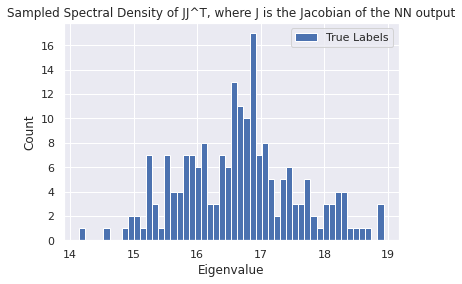

In [14]:
plt.hist(u[:,0].detach().cpu().numpy(), alpha=1., bins=50, log=False, label= "True Labels")
plt.title("Sampled Spectral Density of JJ^T, where J is the Jacobian of the NN output")
plt.xlabel("Eigenvalue")
plt.ylabel("Count")
plt.legend()